<a href="https://colab.research.google.com/github/enogjyli/PPCA/blob/main/Functional_Data_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from methods import GuptaPPCA
from methods import GrassPPCA
from methods import KernelPPCA
from methods import binPCA
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 100)
def F(a, b, c, d):
  return b*np.exp(-100*(x-a/2)**2) + c*np.exp(-100*(x+a/2)**2) + 1e-1*d*np.sin(np.pi*x)

def sampler(seed):
  np.random.seed(seed)
  a, b, c, d = 2*np.random.rand(4)-1
  u = F(a, b, c, d)
  return a, u

data = {'theta':[]}
data.update({'u%d' % (i+1):[] for i in range(len(x))})

for seed in range(500):
  a, u = sampler(seed)
  data['theta'].append(a)
  for i in range(len(x)):
    data['u%d' % (i+1)].append(u[i])

data = pd.DataFrame(data)
xdata = data.values[:,1:]
thetadata = data['theta'].values

In [2]:
data_test = {'theta':[]}
data_test.update({'u%d' % (i+1):[] for i in range(len(x))})

for seed in range(500):
  a, u = sampler(seed+500)
  data_test['theta'].append(a)
  for i in range(len(x)):
    data_test['u%d' % (i+1)].append(u[i])

data_test = pd.DataFrame(data_test)
xdata_test = data_test.values[:,1:]
thetadata_test = data_test['theta'].values

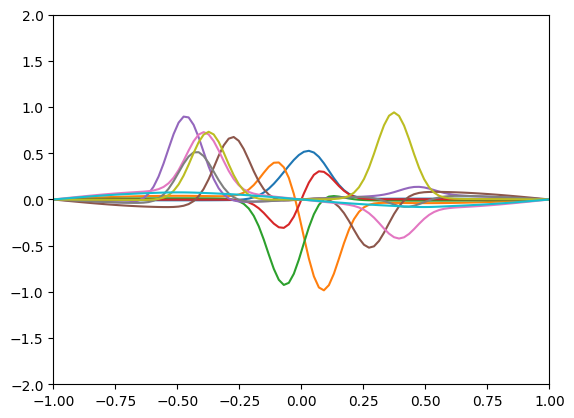

In [3]:
import matplotlib.pyplot as plt
for j in range(10):
  plt.plot(x, data.iloc[j, 1:])
plt.axis([-1, 1, -2, 2])
plt.show()

In [4]:

bins = np.linspace(-1, 1, 5)
m = 3

In [5]:
# Standard PCA
pca = PCA(n_components=m)
data_red_PCA = pca.fit_transform(xdata)
data_PCA = pca.inverse_transform(data_red_PCA)

proj_test_PCA = pca.transform(xdata_test)
data_test_PCA = pca.inverse_transform(proj_test_PCA)

# Sparse PCA
spca = SparsePCA(n_components=m).fit(xdata)
spca_transf = spca.transform(xdata)
data_SPCA = (spca_transf @ spca.components_) + spca.mean_

proj_test_SPCA = spca.transform(xdata_test)
data_test_SPCA = (proj_test_SPCA @ spca.components_) + spca.mean_

# IPCA
ipca = binPCA(bins,m)
ipca.fit(thetadata,xdata)
proj_IPCA = ipca.transform(thetadata,xdata)
data_IPCA = ipca.inverse_transform(thetadata,proj_IPCA)

proj_test_IPCA = ipca.transform(thetadata_test,xdata_test)
data_test_IPCA = ipca.inverse_transform(thetadata_test,proj_test_IPCA)

# PPCA
gupta = GuptaPPCA(bins,m)
gupta.fit(thetadata,xdata,maxiter=1)
proj_PPCA = gupta.transform(thetadata,xdata)
data_PPCA = gupta.inverse_transform(thetadata,proj_PPCA)

proj_test_PPCA = gupta.transform(thetadata_test,xdata_test)
data_test_PPCA = gupta.inverse_transform(thetadata_test,proj_test_PPCA)

# Kernel PCA
def kernel(theta_new, theta_i, gamma=0.5):
    return np.exp(-((theta_new-theta_i)**2)/gamma)

kerpca = KernelPPCA(thetadata,xdata,m, kernel)
proj_ker = kerpca.transform(thetadata,xdata)
data_ker = kerpca.inverse_transform(thetadata,proj_ker)

proj_test_ker = kerpca.transform(thetadata_test,xdata_test)
data_test_ker = kerpca.inverse_transform(thetadata_test,proj_test_ker)

# Interpolation PCA
grass = GrassPPCA(bins,m)
grass.fit(thetadata,xdata)
proj_grass = grass.transform(thetadata,xdata)
data_grass = grass.inverse_transform(thetadata,proj_grass)

proj_test_grass = grass.transform(thetadata_test,xdata_test)
data_test_grass = grass.inverse_transform(thetadata_test,proj_test_grass)
names = ['PCA','SPCA','binPCA','PPCA','Grass','Kernel']
for name,xrec in zip(names,[data_test_PCA, data_test_SPCA, data_test_IPCA, data_test_PPCA, data_test_grass, data_test_ker]):
    print("%s : %.2f" % (name,np.sqrt(mean_squared_error(xdata, xrec))))


PCA : 0.26
SPCA : 0.26
binPCA : 0.28
PPCA : 0.26
Grass : 0.28
Kernel : 0.28


In [10]:
grass = GrassPPCA(np.linspace(-1,1,10),m)
grass.fit(thetadata,xdata)

proj_test_grass = grass.transform(thetadata_test,xdata_test)
data_test_grass = grass.inverse_transform(thetadata_test,proj_test_grass)

for name,xrec in zip(names,[data_test_PCA, data_test_SPCA, data_test_IPCA, data_test_PPCA, data_test_grass, data_test_ker]):
    print("%s : %.2f" % (name,np.sqrt(mean_squared_error(xdata, xrec))))

PCA : 0.26
SPCA : 0.26
binPCA : 0.28
PPCA : 0.26
Grass : 0.29
Kernel : 0.28


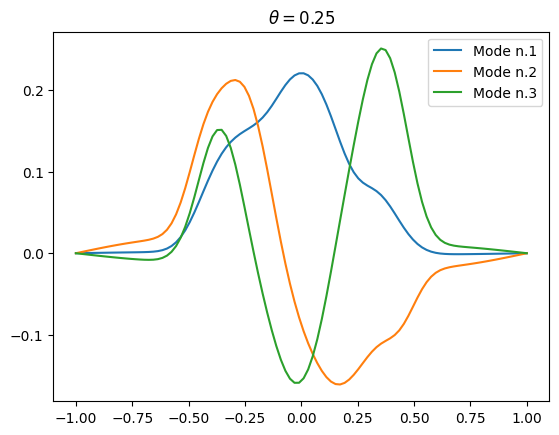

In [14]:
theta = 0.25
P = grass.predict(theta)
P = pca.components_[:m].T
for j in range(m):
  plt.plot(x, P[:,j], label = 'Mode n.%d' % (j+1))
plt.title("$\\theta = %.2f$" % theta)
plt.legend()
plt.show()